## Mujoco with TSID and MPC Example 
This examples, load a basic robot model (i.e. composed only of basic shapes), modifies the links of such a robot model by elongating the legs, define instances of the TSID (Task Based Inverse Dynamics) and Centroidal MPC  controller and simulate the behavior of the robot using mujoco.  

In [ ]:
# Comodo import
from comodo.mujocoSimulator.mujocoSimulator import MujocoSimulator
from comodo.robotModel.robotModel import RobotModel
from comodo.robotModel.createUrdf import createUrdf
from comodo.centroidalMPC.centroidalMPC import CentroidalMPC
from comodo.centroidalMPC.mpcParameterTuning import MPCParameterTuning
from comodo.TSIDController.TSIDParameterTuning import TSIDParameterTuning
from comodo.TSIDController.TSIDController import TSIDController

In [ ]:
# General  import
import xml.etree.ElementTree as ET
import numpy as np
import tempfile
import urllib.request

In [ ]:
# Getting stickbot urdf file and convert it to string
urdf_robot_file = tempfile.NamedTemporaryFile(mode="w+")
url = "https://raw.githubusercontent.com/icub-tech-iit/ergocub-gazebo-simulations/master/models/stickBot/model.urdf"
urllib.request.urlretrieve(url, urdf_robot_file.name)
# Load the URDF file
tree = ET.parse(urdf_robot_file.name)
root = tree.getroot()

# Convert the XML tree to a string
robot_urdf_string_original = ET.tostring(root)

create_urdf_instance = createUrdf(
    original_urdf_path=urdf_robot_file.name, save_gazebo_plugin=False
)

In [ ]:
# Define parametric links and controlled joints
legs_link_names = ["hip_3", "lower_leg"]
joint_name_list = [
    "r_shoulder_pitch",
    "r_shoulder_roll",
    "r_shoulder_yaw",
    "r_elbow",
    "l_shoulder_pitch",
    "l_shoulder_roll",
    "l_shoulder_yaw",
    "l_elbow",
    "r_hip_pitch",
    "r_hip_roll",
    "r_hip_yaw",
    "r_knee",
    "r_ankle_pitch",
    "r_ankle_roll",
    "l_hip_pitch",
    "l_hip_roll",
    "l_hip_yaw",
    "l_knee",
    "l_ankle_pitch",
    "l_ankle_roll",
]

In [ ]:
# Define the robot modifications
modifications = {}
for item in legs_link_names:
    left_leg_item = "l_" + item
    right_leg_item = "r_" + item
    modifications.update({left_leg_item: 1.2})
    modifications.update({right_leg_item: 1.2})
# Motors Parameters
Im_arms = 1e-3 * np.ones(4)  # from 0-4
Im_legs = 1e-3 * np.ones(6)  # from 5-10
kv_arms = 0.001 * np.ones(4)  # from 11-14
kv_legs = 0.001 * np.ones(6)  # from 20

Im = np.concatenate((Im_arms, Im_arms, Im_legs, Im_legs))
kv = np.concatenate((kv_arms, kv_arms, kv_legs, kv_legs))

In [ ]:
# Modify the robot model and initialize
create_urdf_instance.modify_lengths(modifications)
urdf_robot_string = create_urdf_instance.write_urdf_to_file()
create_urdf_instance.reset_modifications()
robot_model_init = RobotModel(urdf_robot_string, "stickBot", joint_name_list)
s_des, xyz_rpy, H_b = robot_model_init.compute_desired_position_walking()

In [34]:
s_des

array([ 0.        ,  0.251     ,  0.        ,  0.616     ,  0.        ,
        0.251     ,  0.        ,  0.616     ,  0.50082726,  0.00300592,
       -0.00164537, -1.        , -0.49917522, -0.00342677,  0.49922533,
        0.00300592, -0.00163911, -1.        , -0.50077713, -0.00342377])

In [35]:
# Define simulator and set initial position
mujoco_instance = MujocoSimulator()
mujoco_instance.load_model(
    robot_model_init, s=s_des, xyz_rpy=xyz_rpy, kv_motors=kv, Im=Im
)
s, ds, tau = mujoco_instance.get_state()
t = mujoco_instance.get_simulation_time()
H_b = mujoco_instance.get_base()
w_b = mujoco_instance.get_base_velocity()
mujoco_instance.set_visualize_robot_flag(True)

In [ ]:
# Define the controller parameters  and instantiate the controller
# Controller Parameters
tsid_parameter = TSIDParameterTuning()
mpc_parameters = MPCParameterTuning()

# TSID Instance
TSID_controller_instance = TSIDController(frequency=0.01, robot_model=robot_model_init)
TSID_controller_instance.define_tasks(tsid_parameter)
TSID_controller_instance.set_state_with_base(s, ds, H_b, w_b, t)

# MPC Instance
step_lenght = 0.1
mpc = CentroidalMPC(robot_model=robot_model_init, step_length=step_lenght)
mpc.intialize_mpc(mpc_parameters=mpc_parameters)

# Set desired quantities
mpc.configure(s_init=s_des, H_b_init=H_b)
TSID_controller_instance.compute_com_position()
mpc.define_test_com_traj(TSID_controller_instance.COM.toNumPy())

# Set initial robot state  and plan trajectories
mujoco_instance.step(1)

# Reading the state
s, ds, tau = mujoco_instance.get_state()
H_b = mujoco_instance.get_base()
w_b = mujoco_instance.get_base_velocity()
t = mujoco_instance.get_simulation_time()

# MPC
mpc.set_state_with_base(s=s, s_dot=ds, H_b=H_b, w_b=w_b, t=t)
mpc.initialize_centroidal_integrator(s=s, s_dot=ds, H_b=H_b, w_b=w_b, t=t)
mpc_output = mpc.plan_trajectory()

In [ ]:
# Set loop variables
TIME_TH = 20

# Define number of steps
n_step = int(
    TSID_controller_instance.frequency / mujoco_instance.get_simulation_frequency()
)
n_step_mpc_tsid = int(mpc.get_frequency_seconds() / TSID_controller_instance.frequency)

counter = 0
mpc_success = True
energy_tot = 0.0
succeded_controller = True

In [ ]:
# Simulation-control loop
while t < TIME_TH:
    # Reading robot state from simulator
    s, ds, tau = mujoco_instance.get_state()
    energy_i = np.linalg.norm(tau)
    H_b = mujoco_instance.get_base()
    w_b = mujoco_instance.get_base_velocity()
    t = mujoco_instance.get_simulation_time()

    # Update TSID
    TSID_controller_instance.set_state_with_base(s=s, s_dot=ds, H_b=H_b, w_b=w_b, t=t)

    # MPC plan
    if counter == 0:
        mpc.set_state_with_base(s=s, s_dot=ds, H_b=H_b, w_b=w_b, t=t)
        mpc.update_references()
        mpc_success = mpc.plan_trajectory()
        mpc.contact_planner.advance_swing_foot_planner()
        if not (mpc_success):
            print("MPC failed")
            break

    # Reading new references
    com, dcom, forces_left, forces_right, ang_mom = mpc.get_references()
    left_foot, right_foot = mpc.contact_planner.get_references_swing_foot_planner()

    # Update references TSID
    TSID_controller_instance.update_task_references_mpc(
        com=com,
        dcom=dcom,
        ddcom=np.zeros(3),
        left_foot_desired=left_foot,
        right_foot_desired=right_foot,
        s_desired=np.array(s_des),
        wrenches_left=forces_left,
        wrenches_right=forces_right,
    )

    # Run control
    succeded_controller = TSID_controller_instance.run()

    if not (succeded_controller):
        print("Controller failed")
        break

    tau = TSID_controller_instance.get_torque()

    # Step the simulator
    mujoco_instance.set_input(tau)
    mujoco_instance.step_with_motors(n_step=n_step, torque=tau)
    counter = counter + 1

    if counter == n_step_mpc_tsid:
        counter = 0

In [ ]:
# Closing visualization
mujoco_instance.close_visualization()

In [ ]:
ref_state

[array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.02972293, -0.00144138,  0.58223778]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03492077, -0.00393788,  0.58207182]),
 array([-0.03642612,

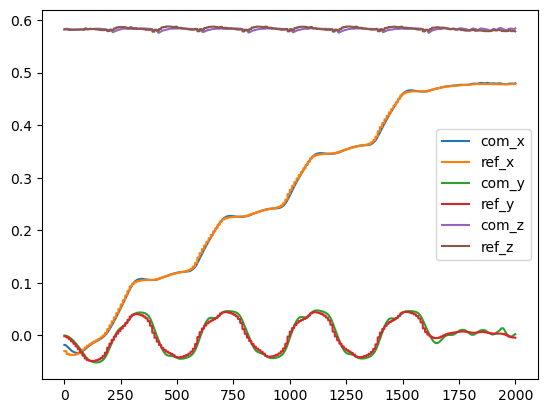

In [ ]:
# Plot the com state and the reference

import matplotlib.pyplot as plt
com_state = np.array(com_state)
ref_state = np.array(ref_state)

plt.plot(com_state[:, 0], label="com_x")
plt.plot(ref_state[:, 0], label="ref_x")
plt.plot(com_state[:, 1], label="com_y")
plt.plot(ref_state[:, 1], label="ref_y")
plt.plot(com_state[:, 2], label="com_z")
plt.plot(ref_state[:, 2], label="ref_z")
plt.legend()
plt.show()